# One Hundred Random Points Generator

##  TLDR: 

Creates 100 random points within defined boundaries.

## Author: 

Tiago Tamagusko (tamagusko@gmail.com)  
Version: 0.1 beta  
Date: 2023-05-25

# Data:

https://nominatim.openstreetmap.org/search.php?q=Lisbon+Portugal&polygon_geojson=1&format=json

In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 82.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 118.6 MB/s eta 0:00:00


In [ ]:
# imports

import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.patches import FancyArrow
import requests
from shapely.geometry import Point, shape

In [ ]:
# functions

def get_city_boundary(city, country):
    """Get the boundary of a city.

    This function sends a request to the OpenStreetMap API to fetch
    the boundary of a city and converts it to a GeoDataFrame.

    Args:
        city (str): The name of the city.
        country (str): The name of the country.

    Returns:
        geopandas.GeoDataFrame: The boundary of the city.
    """
    url = (f"https://nominatim.openstreetmap.org/search?city={city}&"
           f"country={country}&format=json&polygon_geojson=1")
    response = requests.get(url).json()
    
    if not response:
        raise ValueError(f"No data available for city: {city}, country: {country}")

    city_boundary_geometry = shape(response[0]['geojson'])
    city_boundary = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[city_boundary_geometry])
    
    return city_boundary


def create_grid_of_points(city_boundary, step):
    """Create a grid of points within a city boundary.

    This function creates a grid of points within a city boundary,
    with a specified distance between each point.

    Args:
        city_boundary (geopandas.GeoDataFrame): The boundary of the city.
        step (float): The distance between each point in degrees.

    Returns:
        geopandas.GeoDataFrame: The grid of points.
    """
    city_polygon = city_boundary.geometry[0]
    minx, miny, maxx, maxy = city_polygon.bounds
    x = np.arange(minx, maxx, step)
    y = np.arange(miny, maxy, step)

    points = [Point(lon, lat) for lon in x for lat in y if city_polygon.contains(Point(lon, lat))]
    points_gdf = gpd.GeoDataFrame(geometry=points, crs="EPSG:4326")
    
    return points_gdf


def plot_city_boundaries(city_boundary):
    """Plot the city boundary and a north indicator.

    Args:
        city_boundary (geopandas.GeoDataFrame): The boundary of the city.

    Returns:
        None
    """
    fig, ax = plt.subplots(dpi=400)
    
    # Plot the city boundaries
    city_boundary.plot(ax=ax, color='white', edgecolor='black')

    # Add a north
    ax.add_patch(FancyArrow(0.9, 0.1, 0.0, 0.06, width=0.015, transform=ax.transAxes, color='k'))
    ax.text(0.9, 0.25, 'N', transform=ax.transAxes, ha='center', va='bottom', fontsize=12)  
    plt.show()
    return fig


def plot_city_and_points(city_boundary, points_gdf):
    """Plot the city boundary and a grid of points.

    Args:
        city_boundary (geopandas.GeoDataFrame): The boundary of the city.
        points_gdf (geopandas.GeoDataFrame): The grid of points.

    Returns:
        None
    """
    fig, ax = plt.subplots(dpi=400)
    city_boundary.plot(ax=ax, color='white', edgecolor='black')
    points_gdf.plot(ax=ax, color='orange', markersize=5)
    # Add a north
    ax.add_patch(FancyArrow(0.9, 0.1, 0.0, 0.06, width=0.015, transform=ax.transAxes, color='k'))
    ax.text(0.9, 0.25, 'N', transform=ax.transAxes, ha='center', va='bottom', fontsize=12)
    plt.show()
    return fig


def meters_to_degrees(distance_meters): # This function will work only for small distances
    """Convert distance in meters to degrees.

    Args:
        distance_meters (float): The distance in meters.

    Returns:
        float: The distance in degrees.
    """
    # 1 degree is approximately 111.32 kilometers at the equator.
    kilometers = distance_meters / 1000
    degrees = kilometers / 111.32
    return degrees


In [ ]:
from scipy.spatial.distance import pdist, squareform

def calculate_pairwise_distances(points_gdf):
    """Calculate the pairwise distances between all points in a grid.

    This function calculates the pairwise distances between all points
    in a grid using the Euclidean distance formula.

    Args:
        points_gdf (geopandas.GeoDataFrame): A grid of points.

    Returns:
        pandas.DataFrame: A DataFrame of pairwise distances.
    """
    # Extract the coordinates from the GeoDataFrame
    coordinates = list(zip(points_gdf.geometry.x, points_gdf.geometry.y))

    # Calculate the pairwise distances using the Euclidean distance formula
    # and convert degrees to meters
    distances = pdist(coordinates, 'euclidean') * 111139  # 1 degree is approximately 111.139 kilometers

    # Convert the pairwise distances to a DataFrame
    distances_df = pd.DataFrame(squareform(distances), index=points_gdf.index, columns=points_gdf.index)

    return distances_df


def extract_point_pairs(points_gdf, distances_df, desired_distance, tolerance):
    """Extract pairs of points that are approximately a desired distance apart.

    This function extracts pairs of points from a DataFrame of pairwise distances that
    are approximately a desired distance apart.

    Args:
        points_gdf (geopandas.GeoDataFrame): A grid of points.
        distances_df (pandas.DataFrame): A DataFrame of pairwise distances.
        desired_distance (float): The desired distance in meters.
        tolerance (float): The tolerance in meters.

    Returns:
        pandas.DataFrame: A DataFrame of pairs of points and their distances.
    """
    # Find pairs of points that are within the tolerance of the desired distance
    pairs = np.where((distances_df >= desired_distance - tolerance) & (distances_df <= desired_distance + tolerance))

    # Extract the coordinates of these pairs of points
    pairs_coordinates = [(points_gdf.iloc[i].geometry, points_gdf.iloc[j].geometry) for i, j in zip(*pairs) if i < j]

    # Prepare the data for the DataFrame
    data = {
        "route_id": np.arange(1, len(pairs_coordinates) + 1),
        "origin_latitude": [pair[0].y for pair in pairs_coordinates],
        "origin_longitude": [pair[0].x for pair in pairs_coordinates],
        "dest_latitude": [pair[1].y for pair in pairs_coordinates],
        "dest_longitude": [pair[1].x for pair in pairs_coordinates],
        "distance": [distances_df.iloc[i, j] for i, j in zip(*pairs) if i < j]
    }

    # Create the DataFrame
    pairs_df = pd.DataFrame(data)

    return pairs_df

In [ ]:
# parameters
city, country = "Lisbon", "Portugal"
city_boundary = get_city_boundary(city, country)
distance_meters = 500 

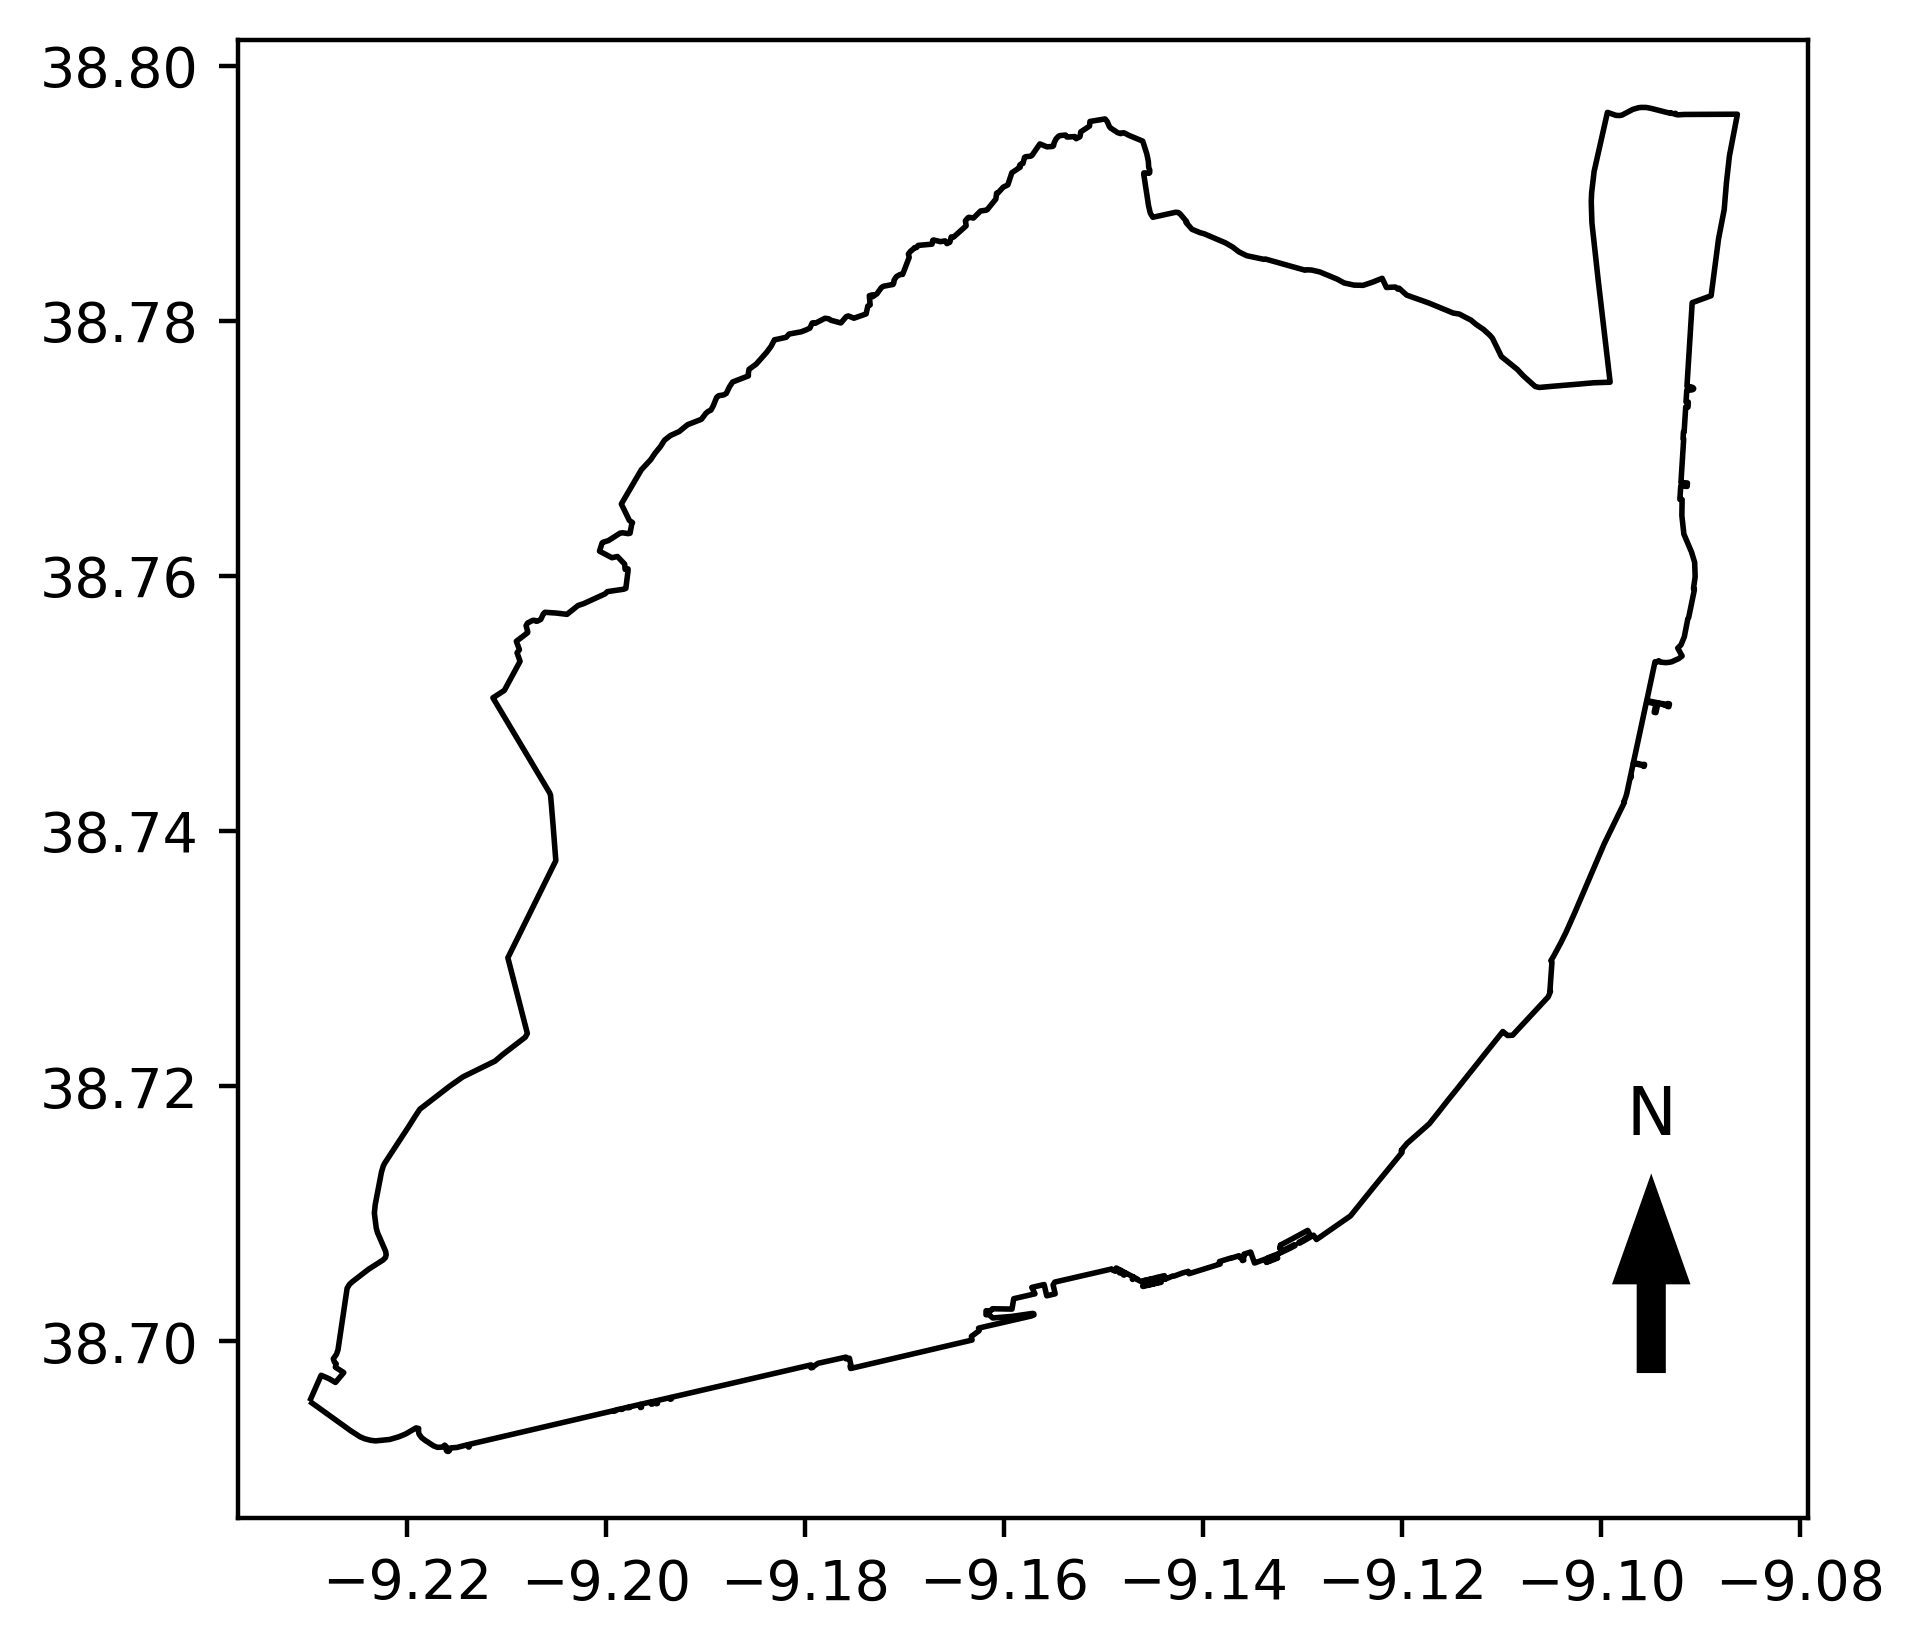

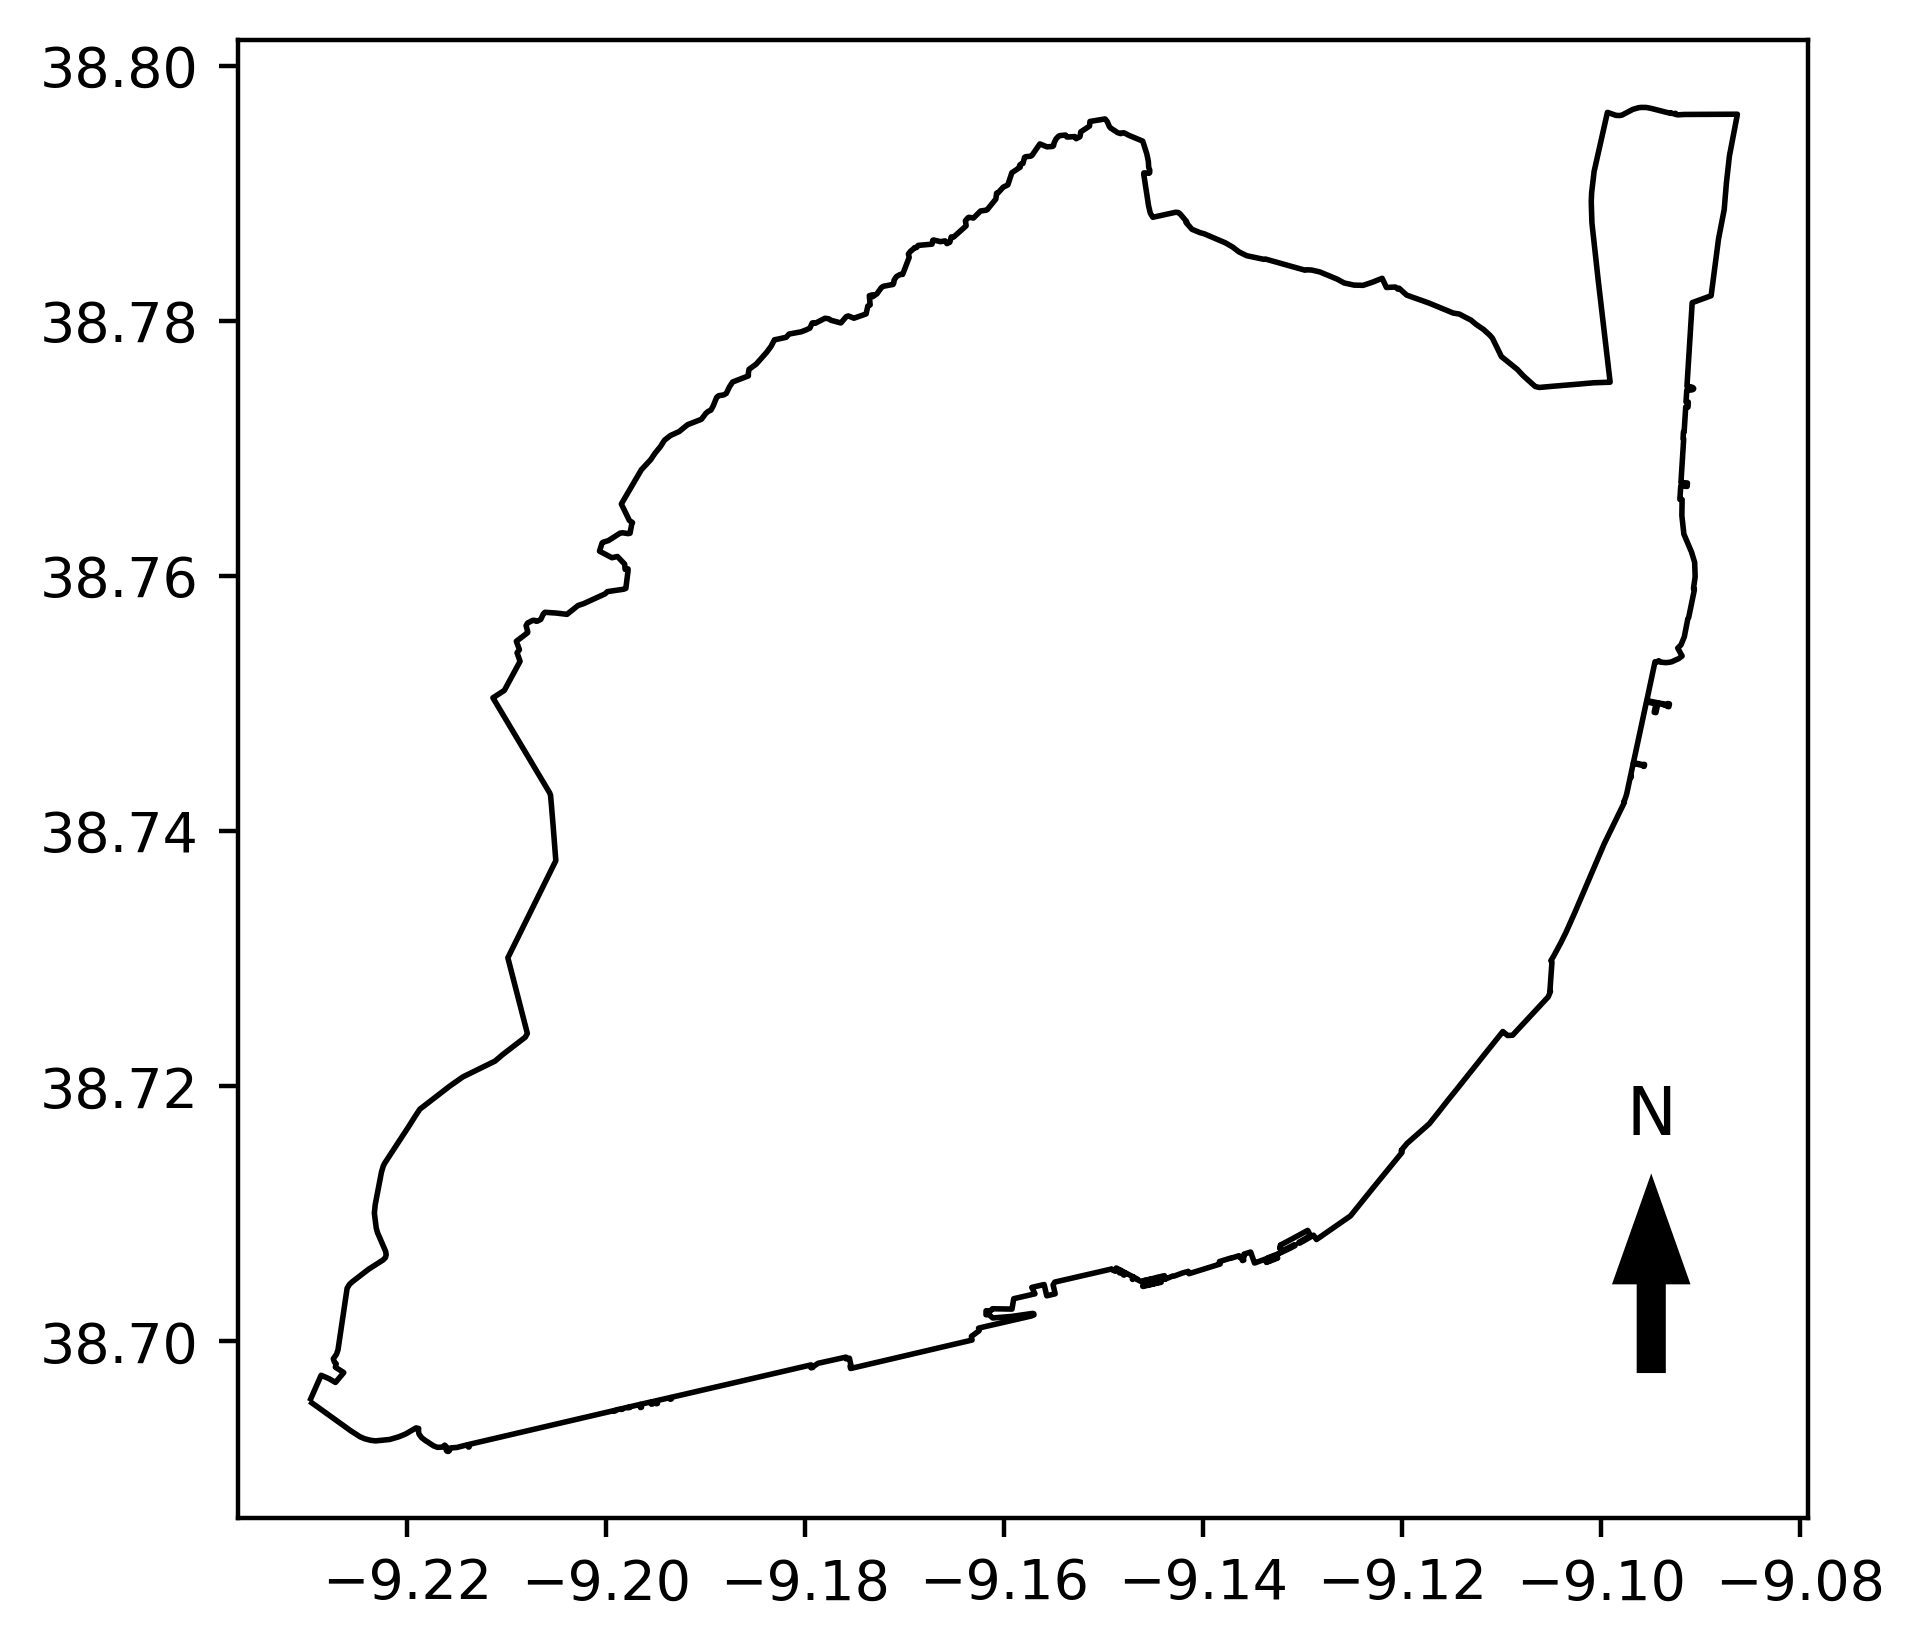

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# plot boundaries
plot_city_boundaries(city_boundary)

# download image
from google.colab import files
plot_city_boundaries(city_boundary).savefig('lisbon.png',  bbox_inches="tight")
files.download('lisbon.png')

Number of points created: 442


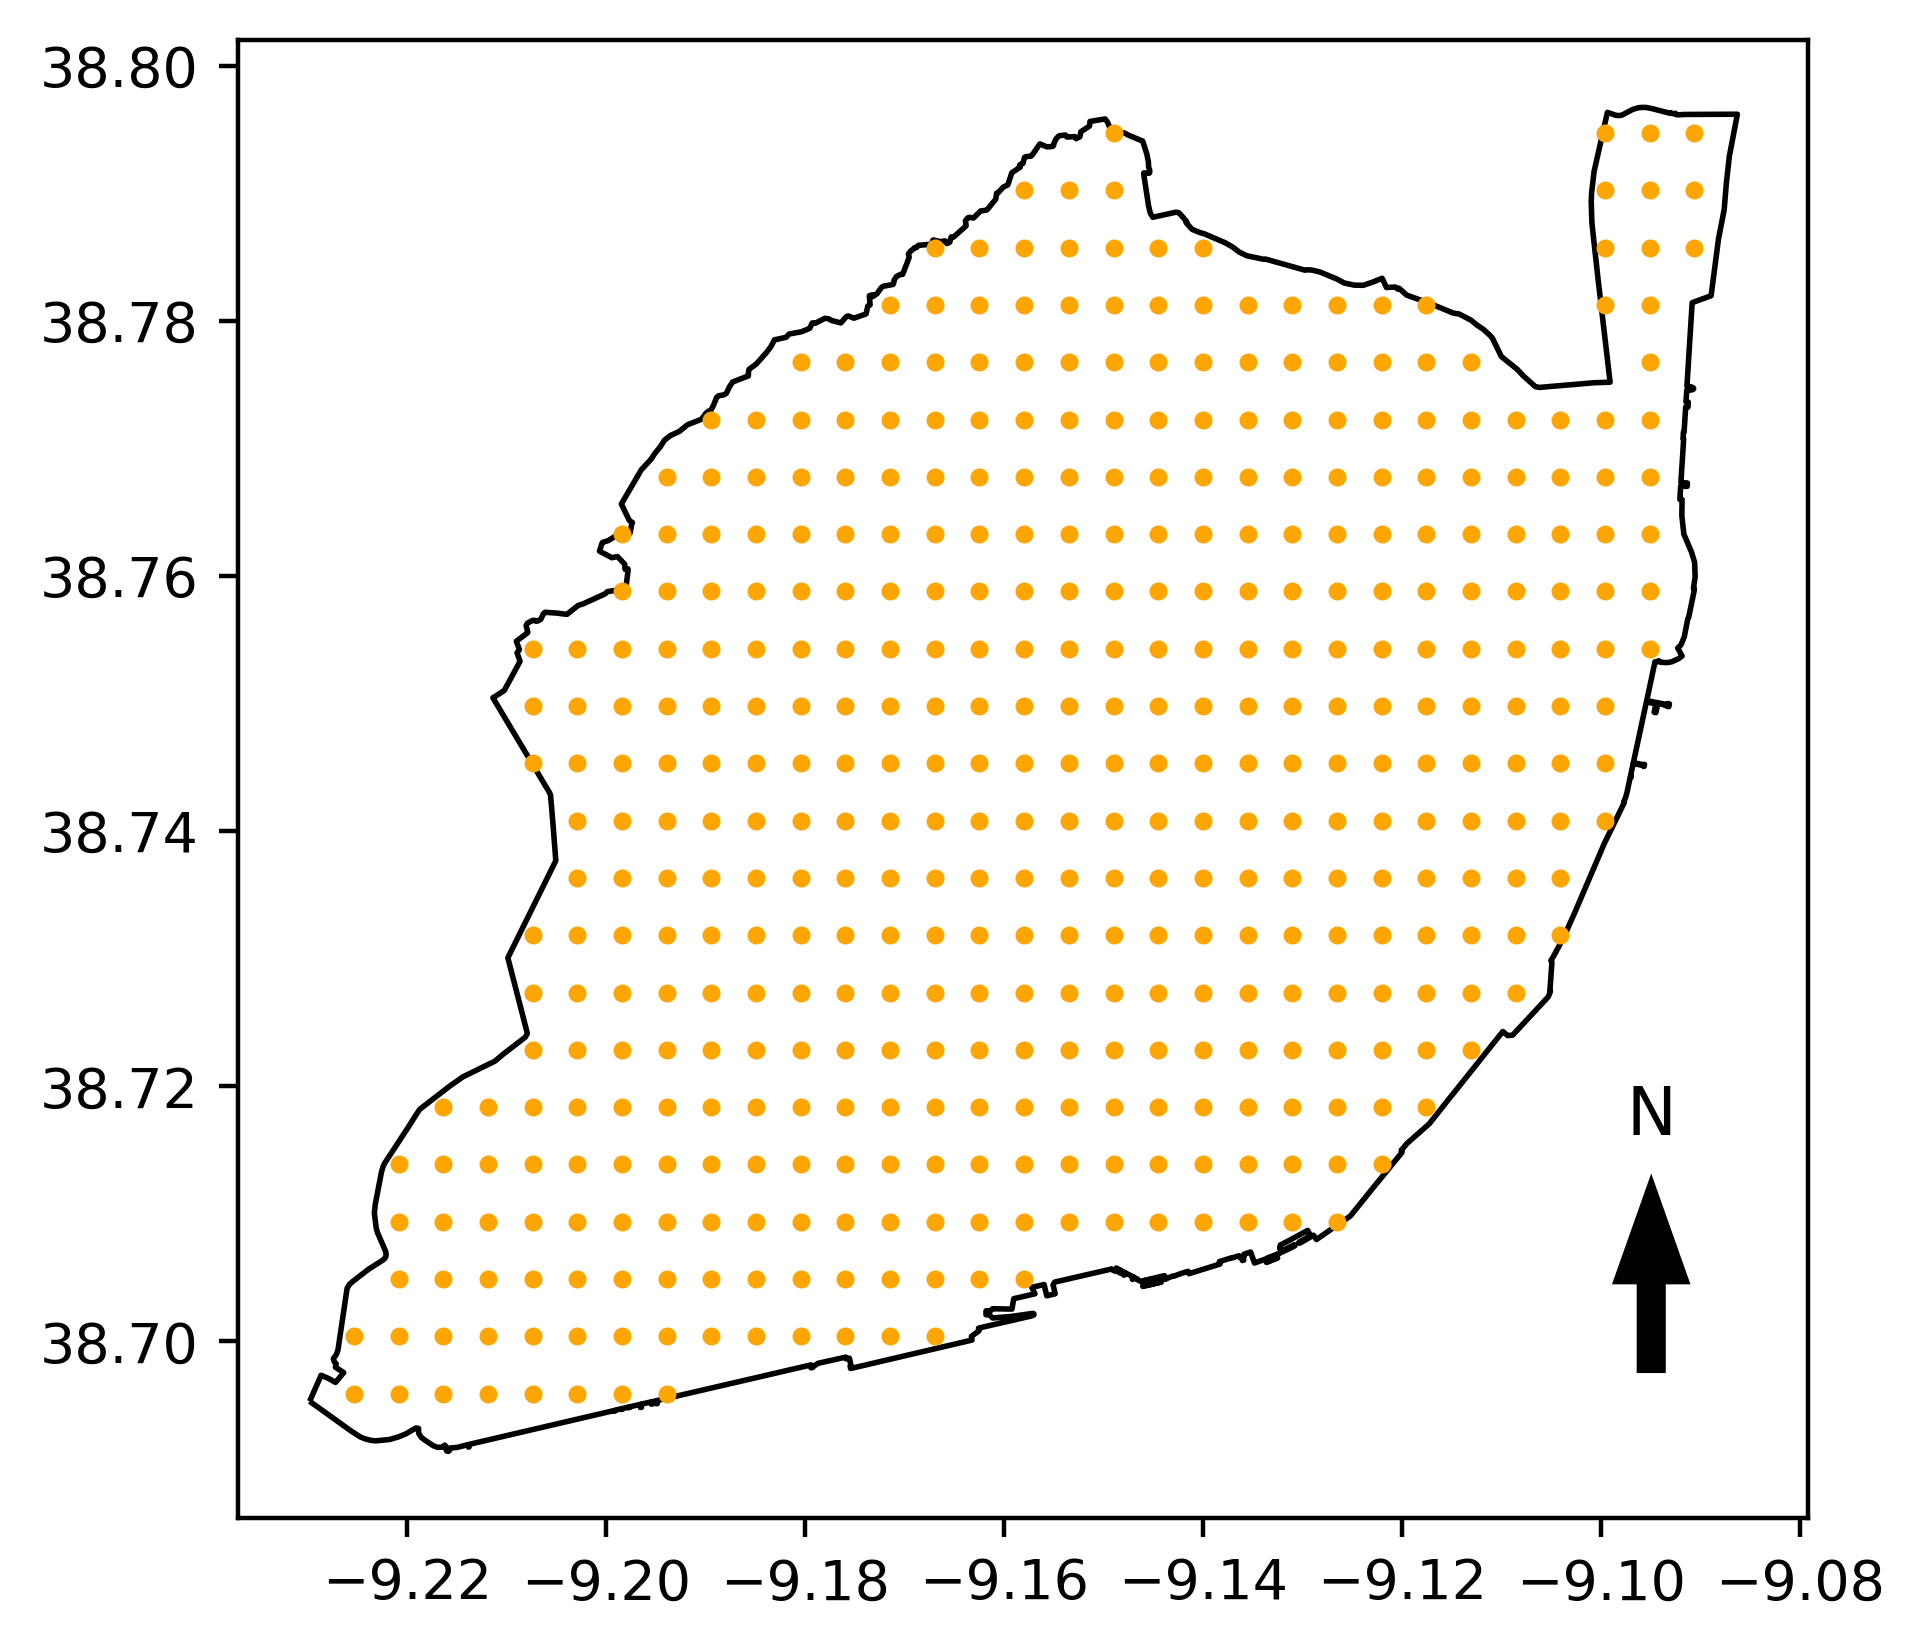

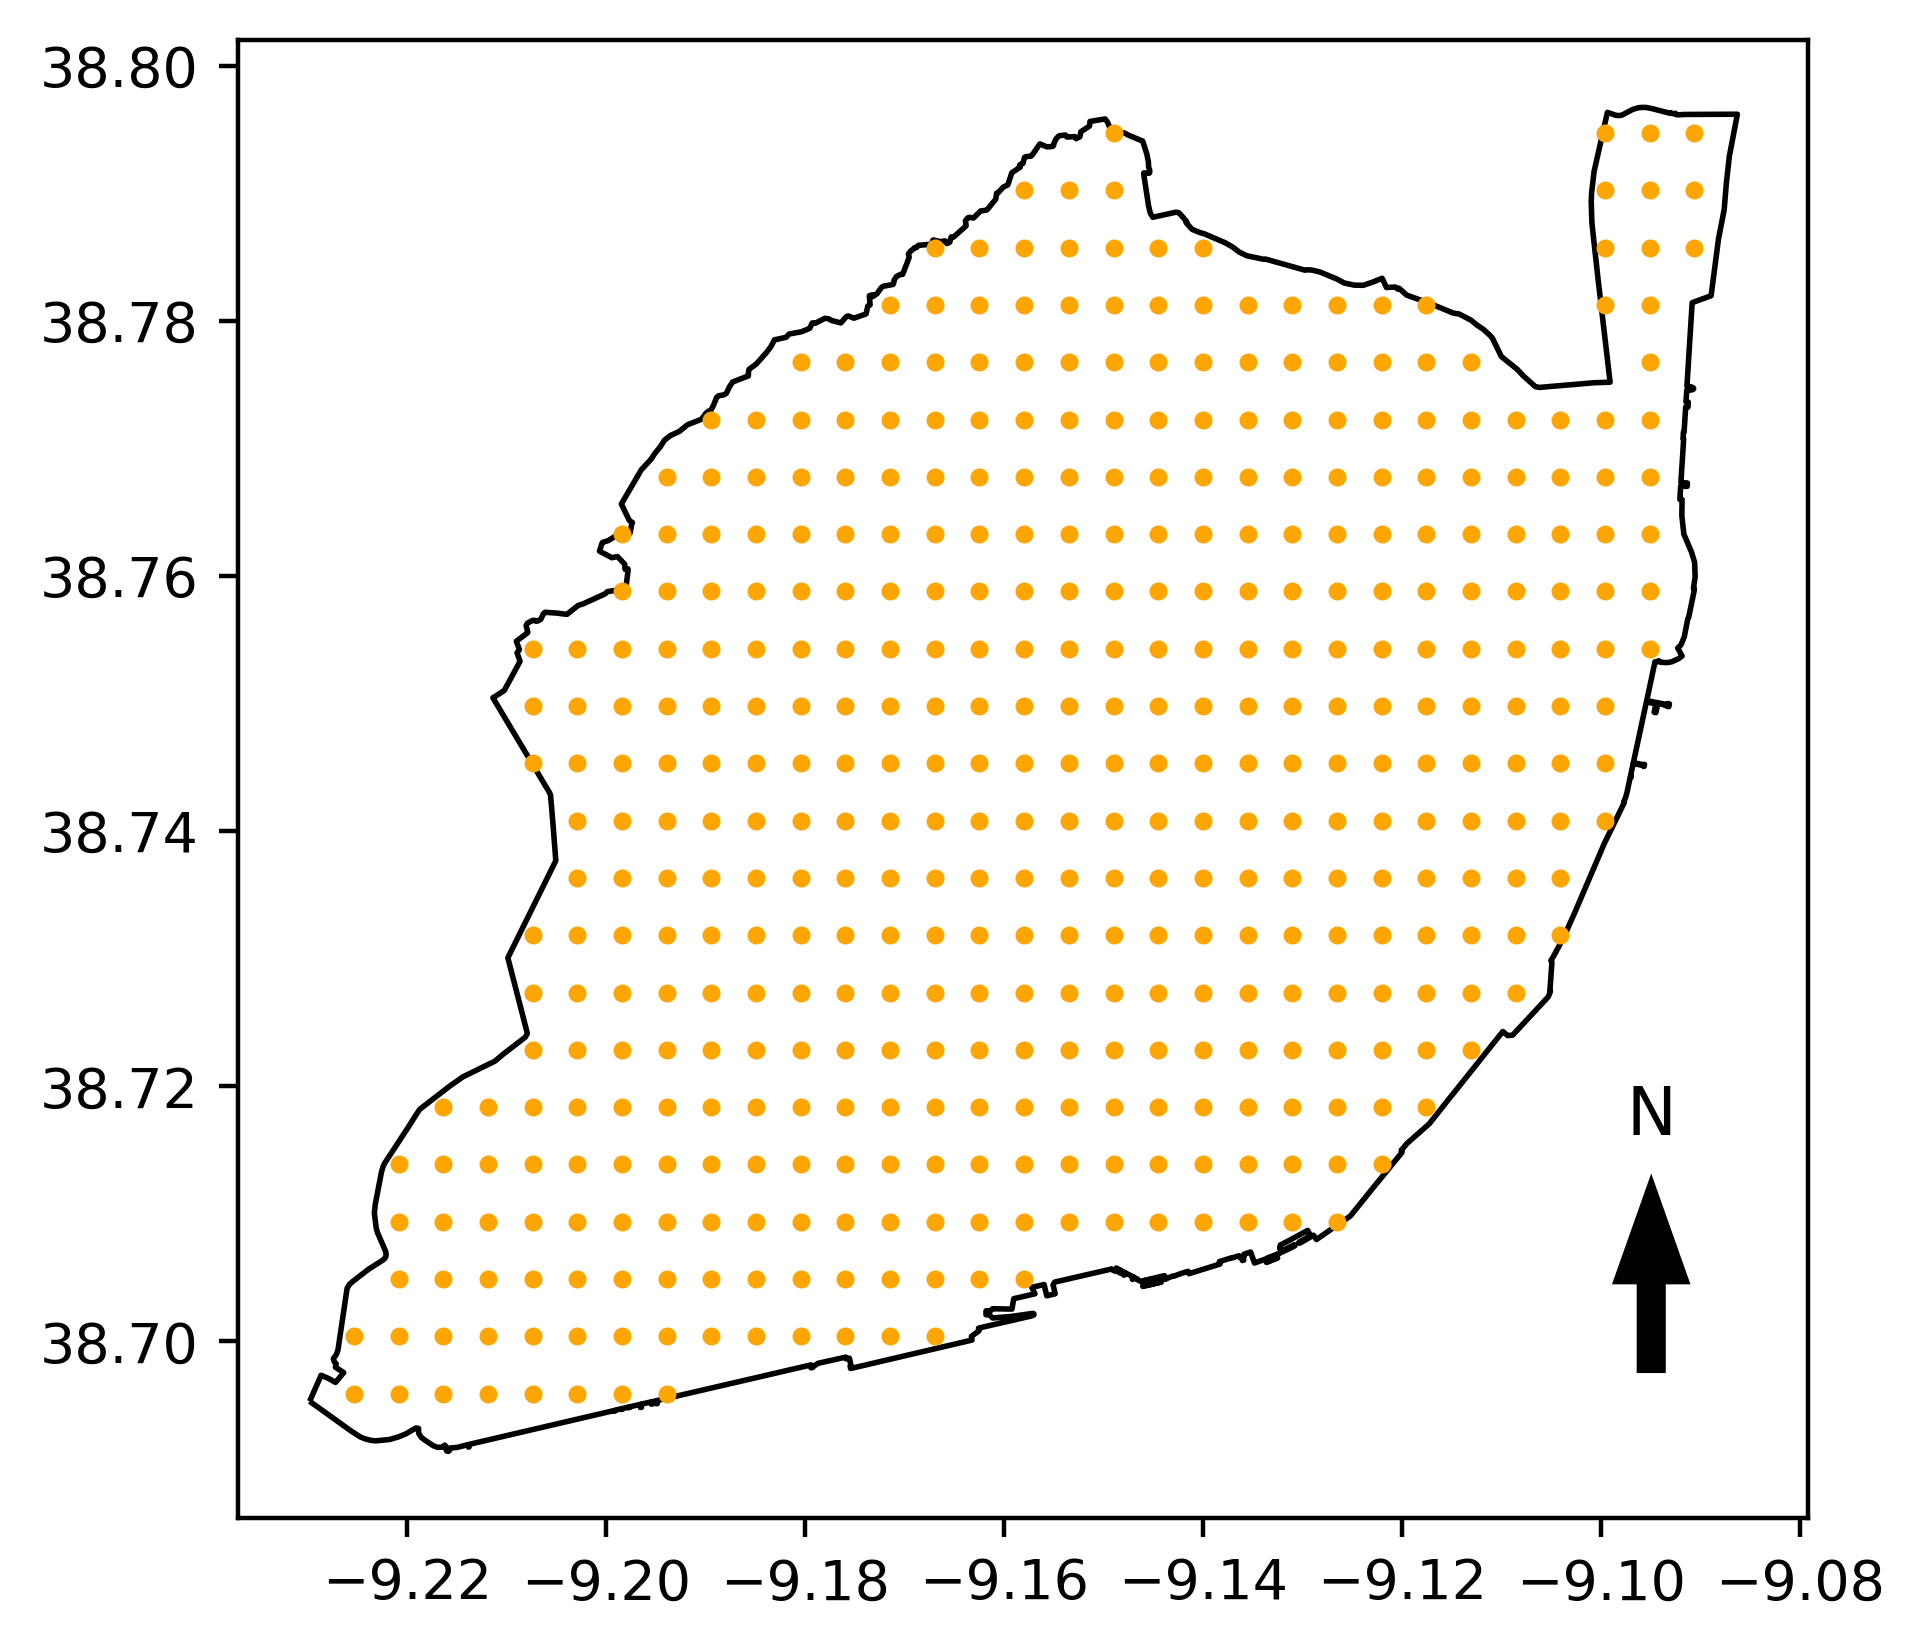

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# plot grid of points

# create grid
points_gdf = create_grid_of_points(city_boundary, step=meters_to_degrees(distance_meters))

print(f"Number of points created: {len(points_gdf)}")
plot_city_and_points(city_boundary, points_gdf)

# download image
# from google.colab import files
plot_city_and_points(city_boundary, points_gdf).savefig('lisbon_grid.png',  bbox_inches="tight")
files.download('lisbon_grid.png')

In [ ]:
# extract pairs of points that are approximately 5000 meters apart, with a tolerance of 10 meters

# calculate the pairwise distances between all points in the grid
distances_df = calculate_pairwise_distances(points_gdf)

distance = 5000
tolerance = 10
pairs_df = extract_point_pairs(points_gdf, distances_df, distance, tolerance)


print(distances_df)
print(pairs_df)

              0             1             2             3             4    \
0        0.000000    499.187028    499.187028    705.957066   1116.216129   
1      499.187028      0.000000    705.957066    499.187028    705.957066   
2      499.187028    705.957066      0.000000    499.187028    998.374057   
3      705.957066    499.187028    499.187028      0.000000    499.187028   
4     1116.216129    705.957066    998.374057    499.187028      0.000000   
..            ...           ...           ...           ...           ...   
437  17873.405319  17585.275728  17471.545994  17176.676749  16891.415105   
438  18170.682110  17873.405319  17775.544719  17471.545994  17176.676749   
439  17998.444269  17726.411826  17585.275728  17306.750202  17038.299740   
440  18280.062674  17998.444269  17873.405319  17585.275728  17306.750202   
441  18570.830945  18280.062674  18170.682110  17873.405319  17585.275728   

              5             6             7             8             9    

In [ ]:
# save outputs

# select 100 random rows
n_random_points = 100
sample_df = pairs_df.sample(n=n_random_points, random_state=1)
sample_df.to_csv('output.csv', index=False)

# export results in google colab.
# from google.colab import files
# files.download('output.csv')

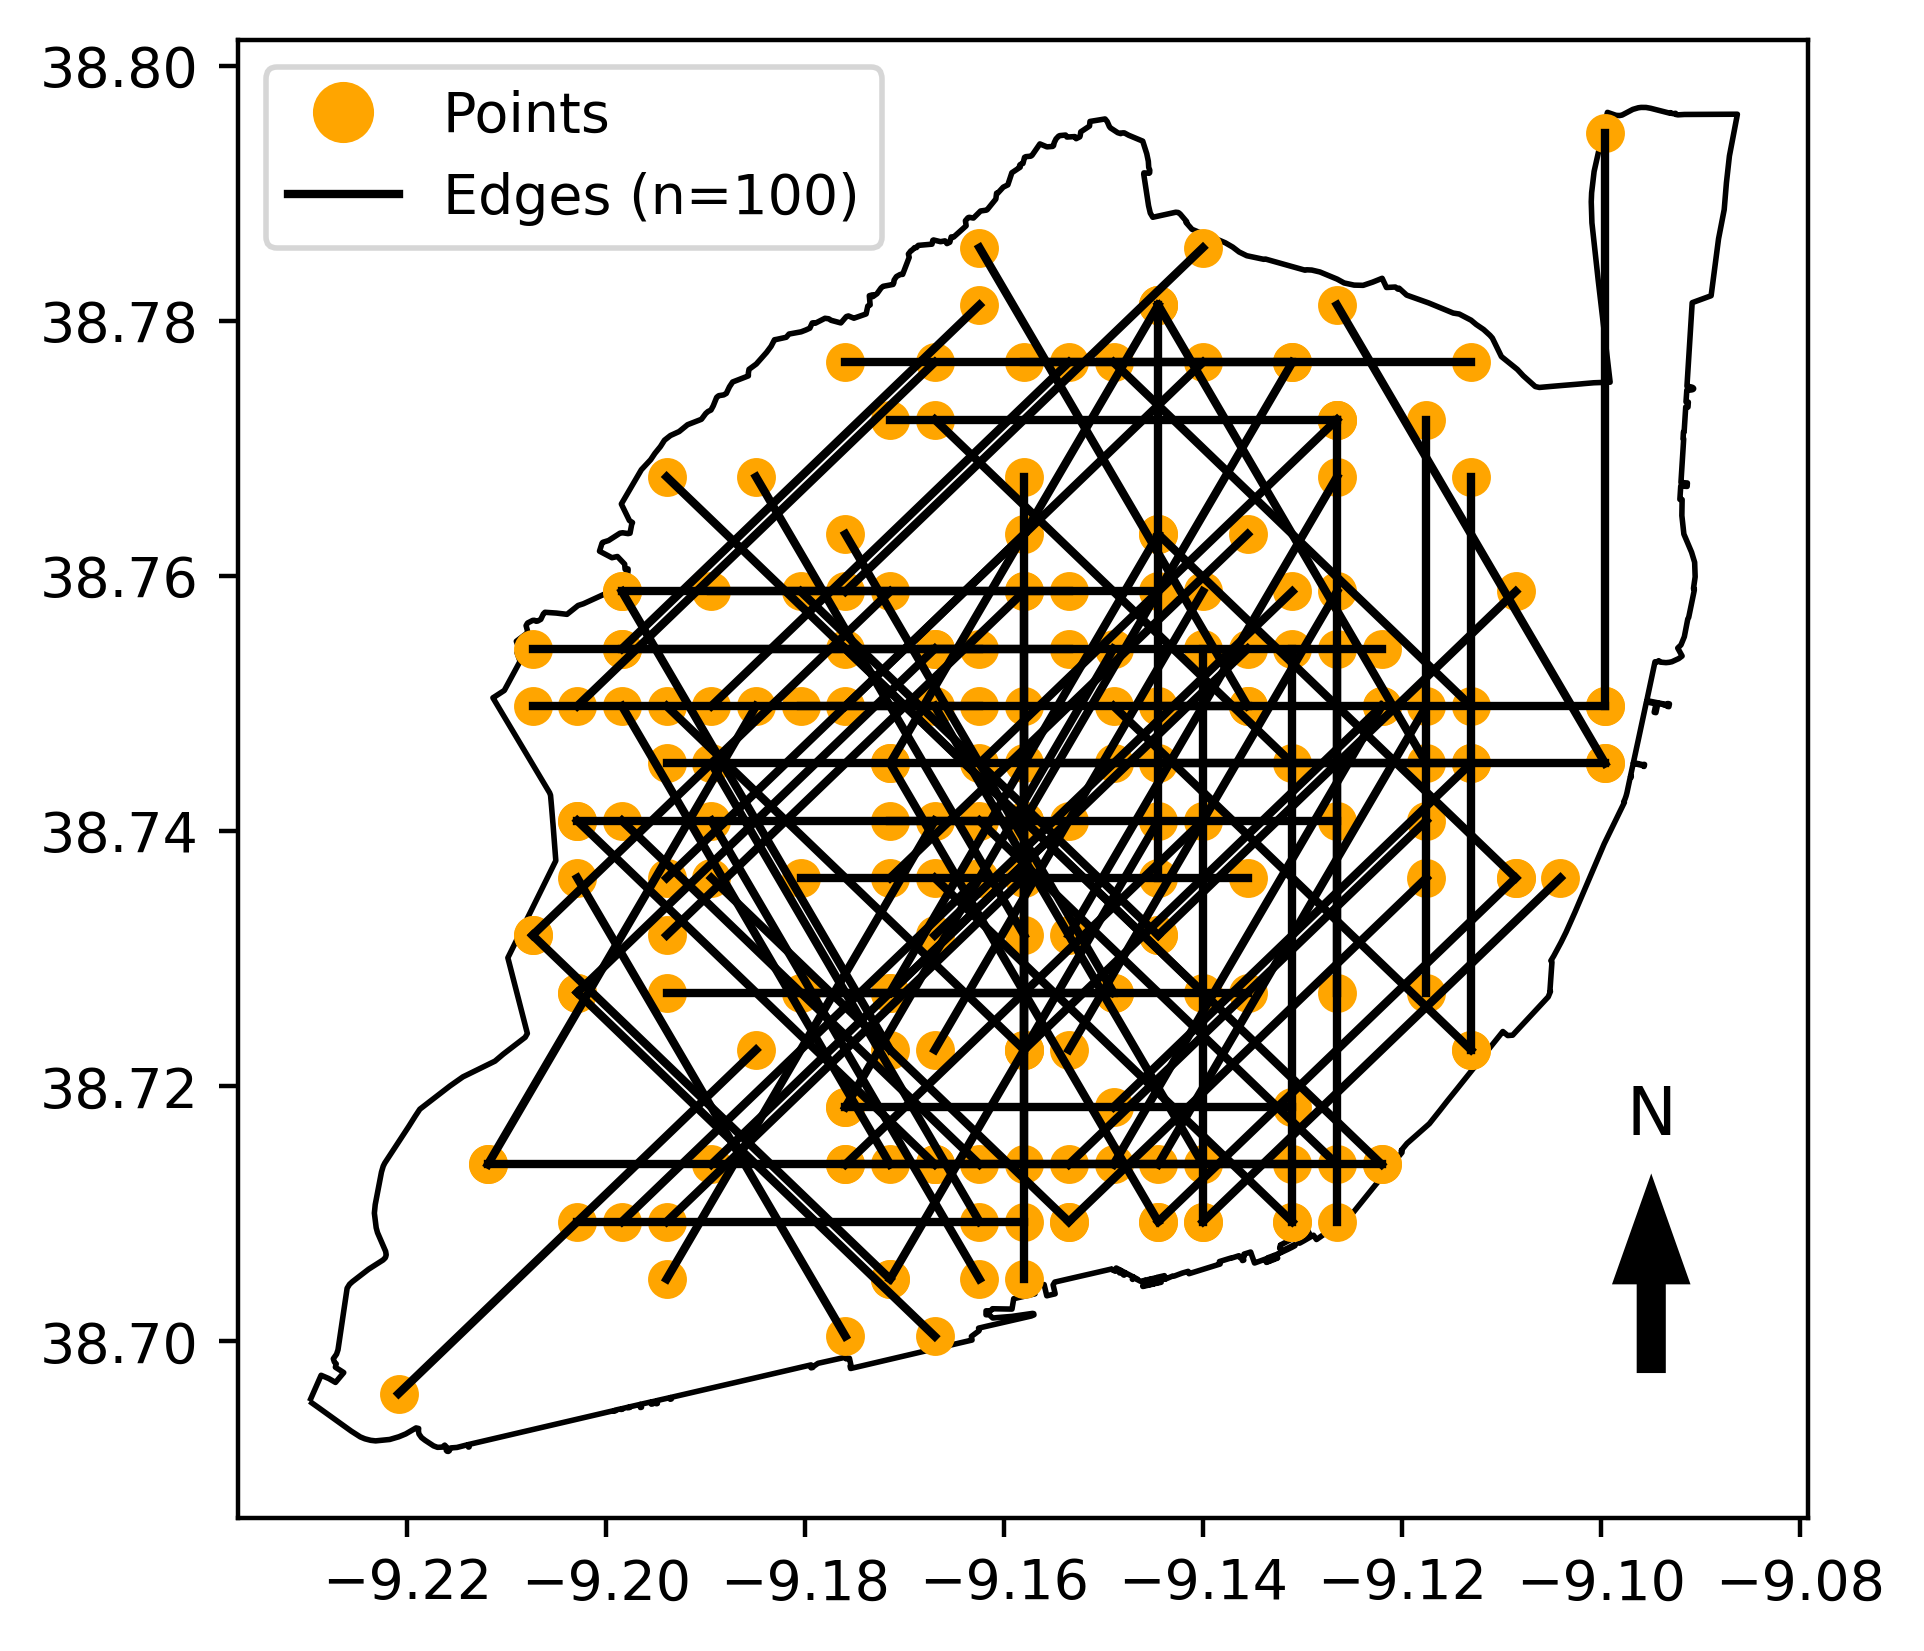

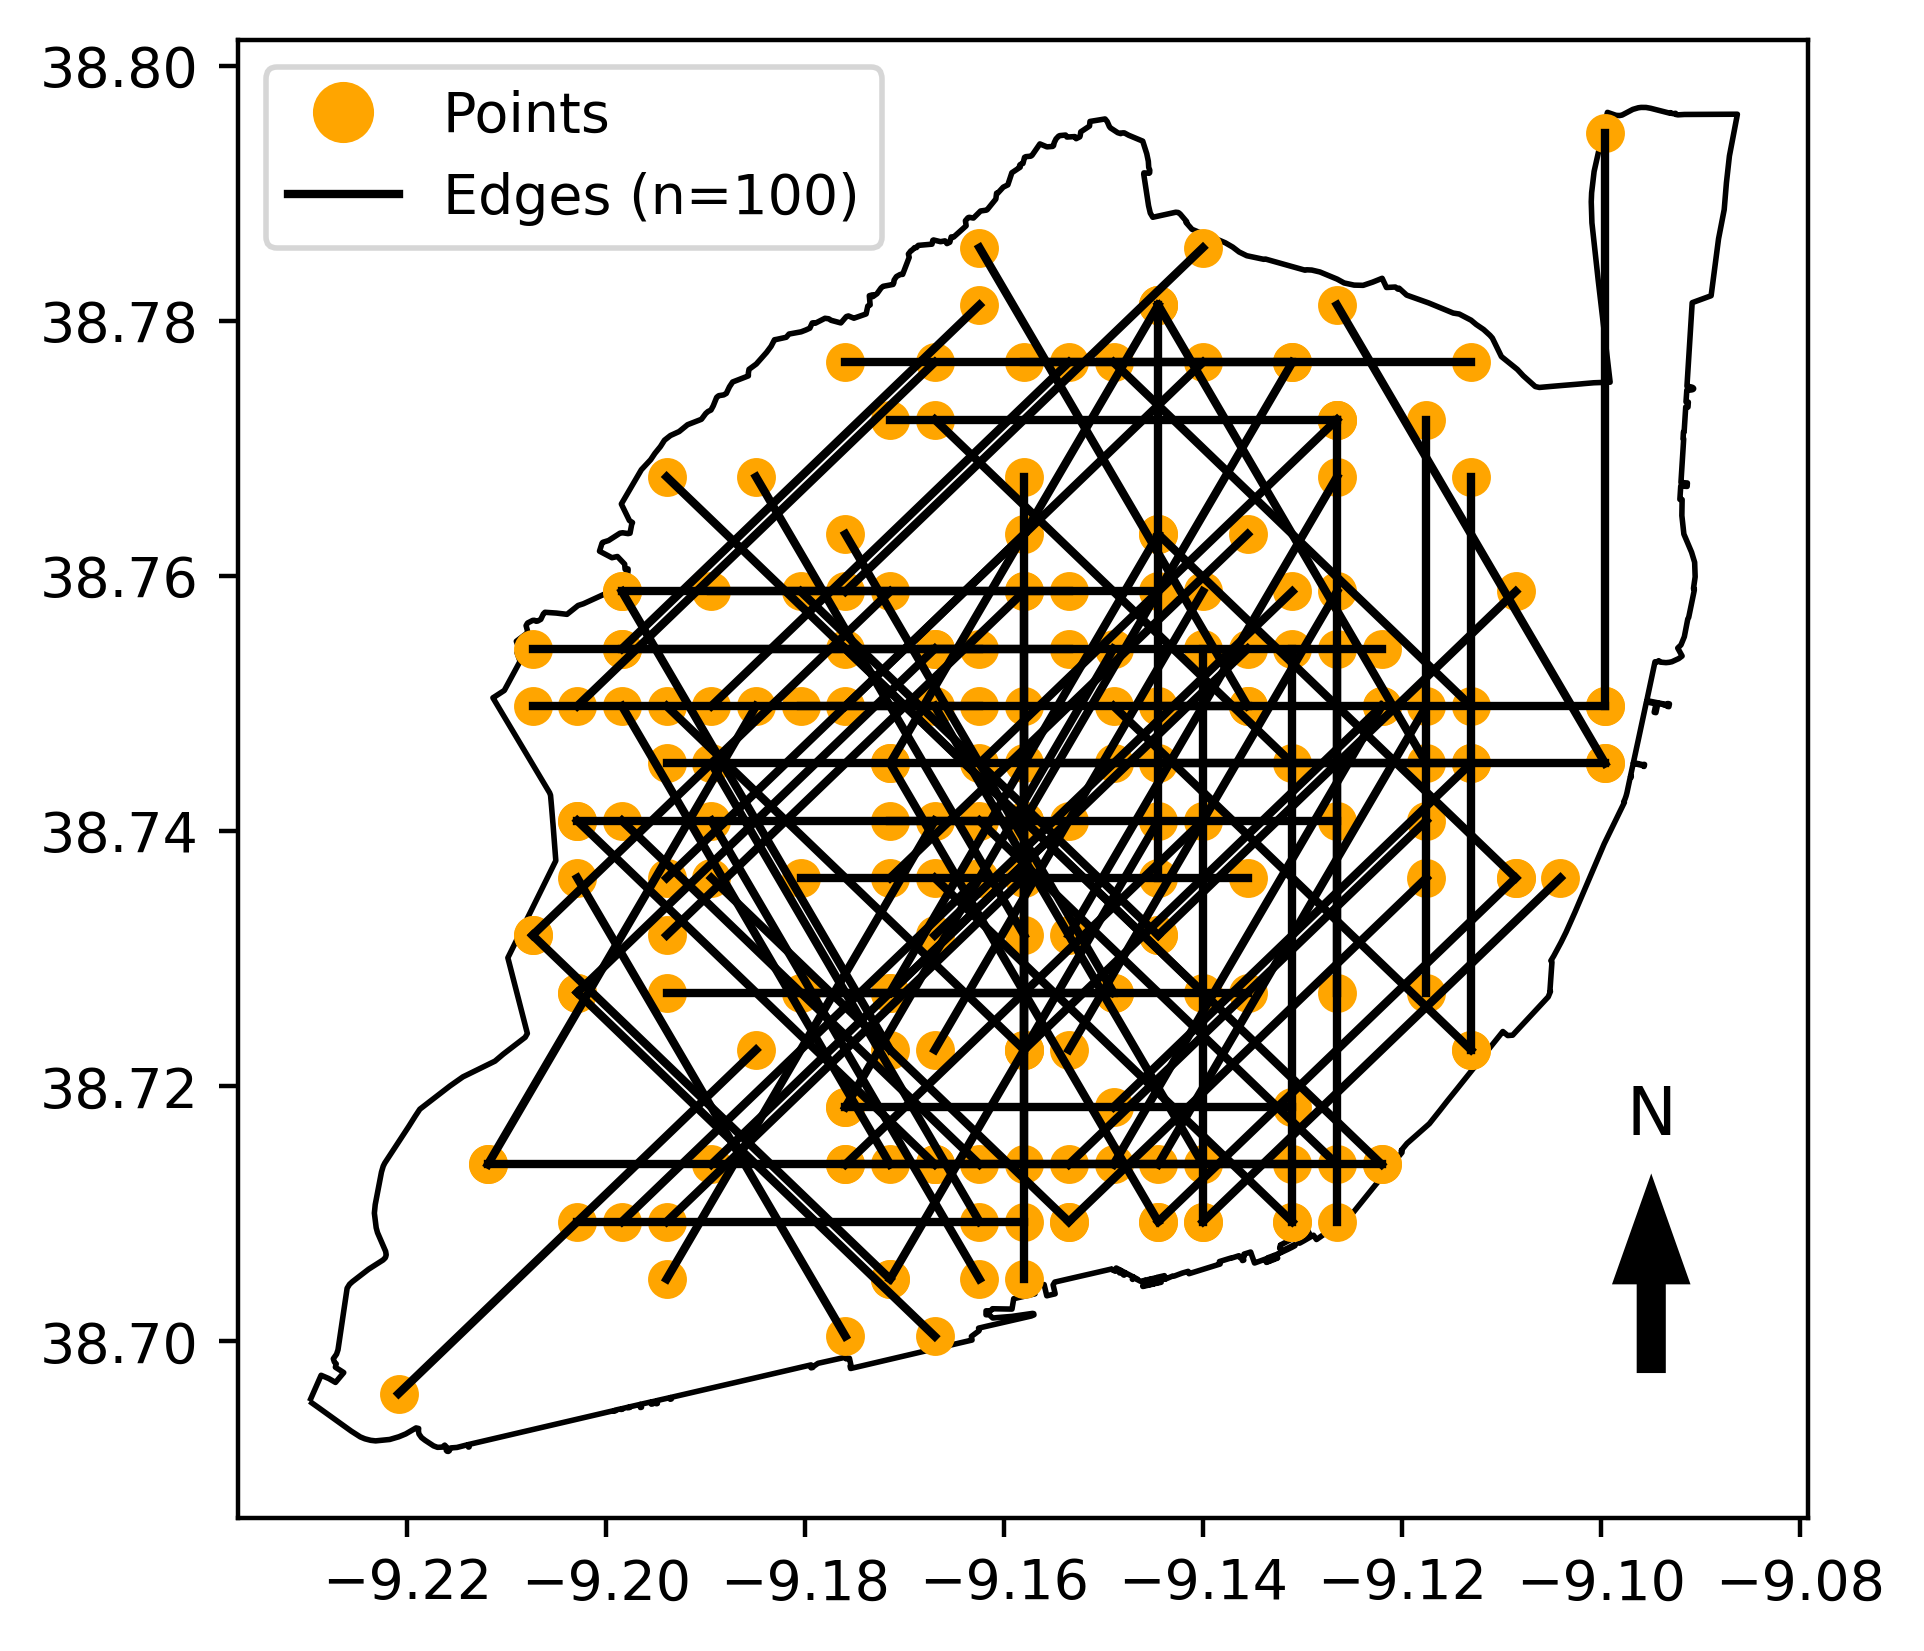

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def plot_points(df, city, country):
    """Plots points within city boundaries.
    
    Args:
        df (pandas.DataFrame): DataFrame with pairs of points. 
        The DataFrame should contain columns 'origin_latitude', 'origin_longitude', 
        'dest_latitude', 'dest_latitude'.
        
        city (str): The name of the city.
        country (str): The name of the country.
    """
    city_boundary = get_city_boundary(city, country)
    fig, ax = plt.subplots(dpi=400)

    # plot city boundaries
    city_boundary.plot(ax=ax, color='white', edgecolor='black')

    # plot origin and destination points in orange
    ax.scatter(df['origin_longitude'], df['origin_latitude'], color='orange')
    ax.scatter(df['dest_longitude'], df['dest_latitude'], color='orange')

    # plot lines connecting origin to destination
    for _, row in df.iterrows():
        ax.plot([row['origin_longitude'], row['dest_longitude']], 
                [row['origin_latitude'], row['dest_latitude']], 
                color='black')
    
    # Add a north
    ax.add_patch(FancyArrow(0.9, 0.1, 0.0, 0.06, width=0.015, transform=ax.transAxes, color='k'))
    ax.text(0.9, 0.25, 'N', transform=ax.transAxes, ha='center', va='bottom', fontsize=12)

    # Create a legend
    orange_patch = mlines.Line2D([], [], color='orange', marker='o', linestyle='None',
                              markersize=10, label=f'Points ')
    black_line = mlines.Line2D([], [], color='black', label=f'Edges (n={len(df)})')

    plt.legend(handles=[orange_patch, black_line])
    plt.show()
    return fig


# Test the function with sample data and city
city = "Lisbon"
country = "Portugal"
plot_points(sample_df, city, country)

# download image
# from google.colab import files
plot_points(sample_df, city, country).savefig('lisbon_routes.png',  bbox_inches="tight")
files.download('lisbon_routes.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

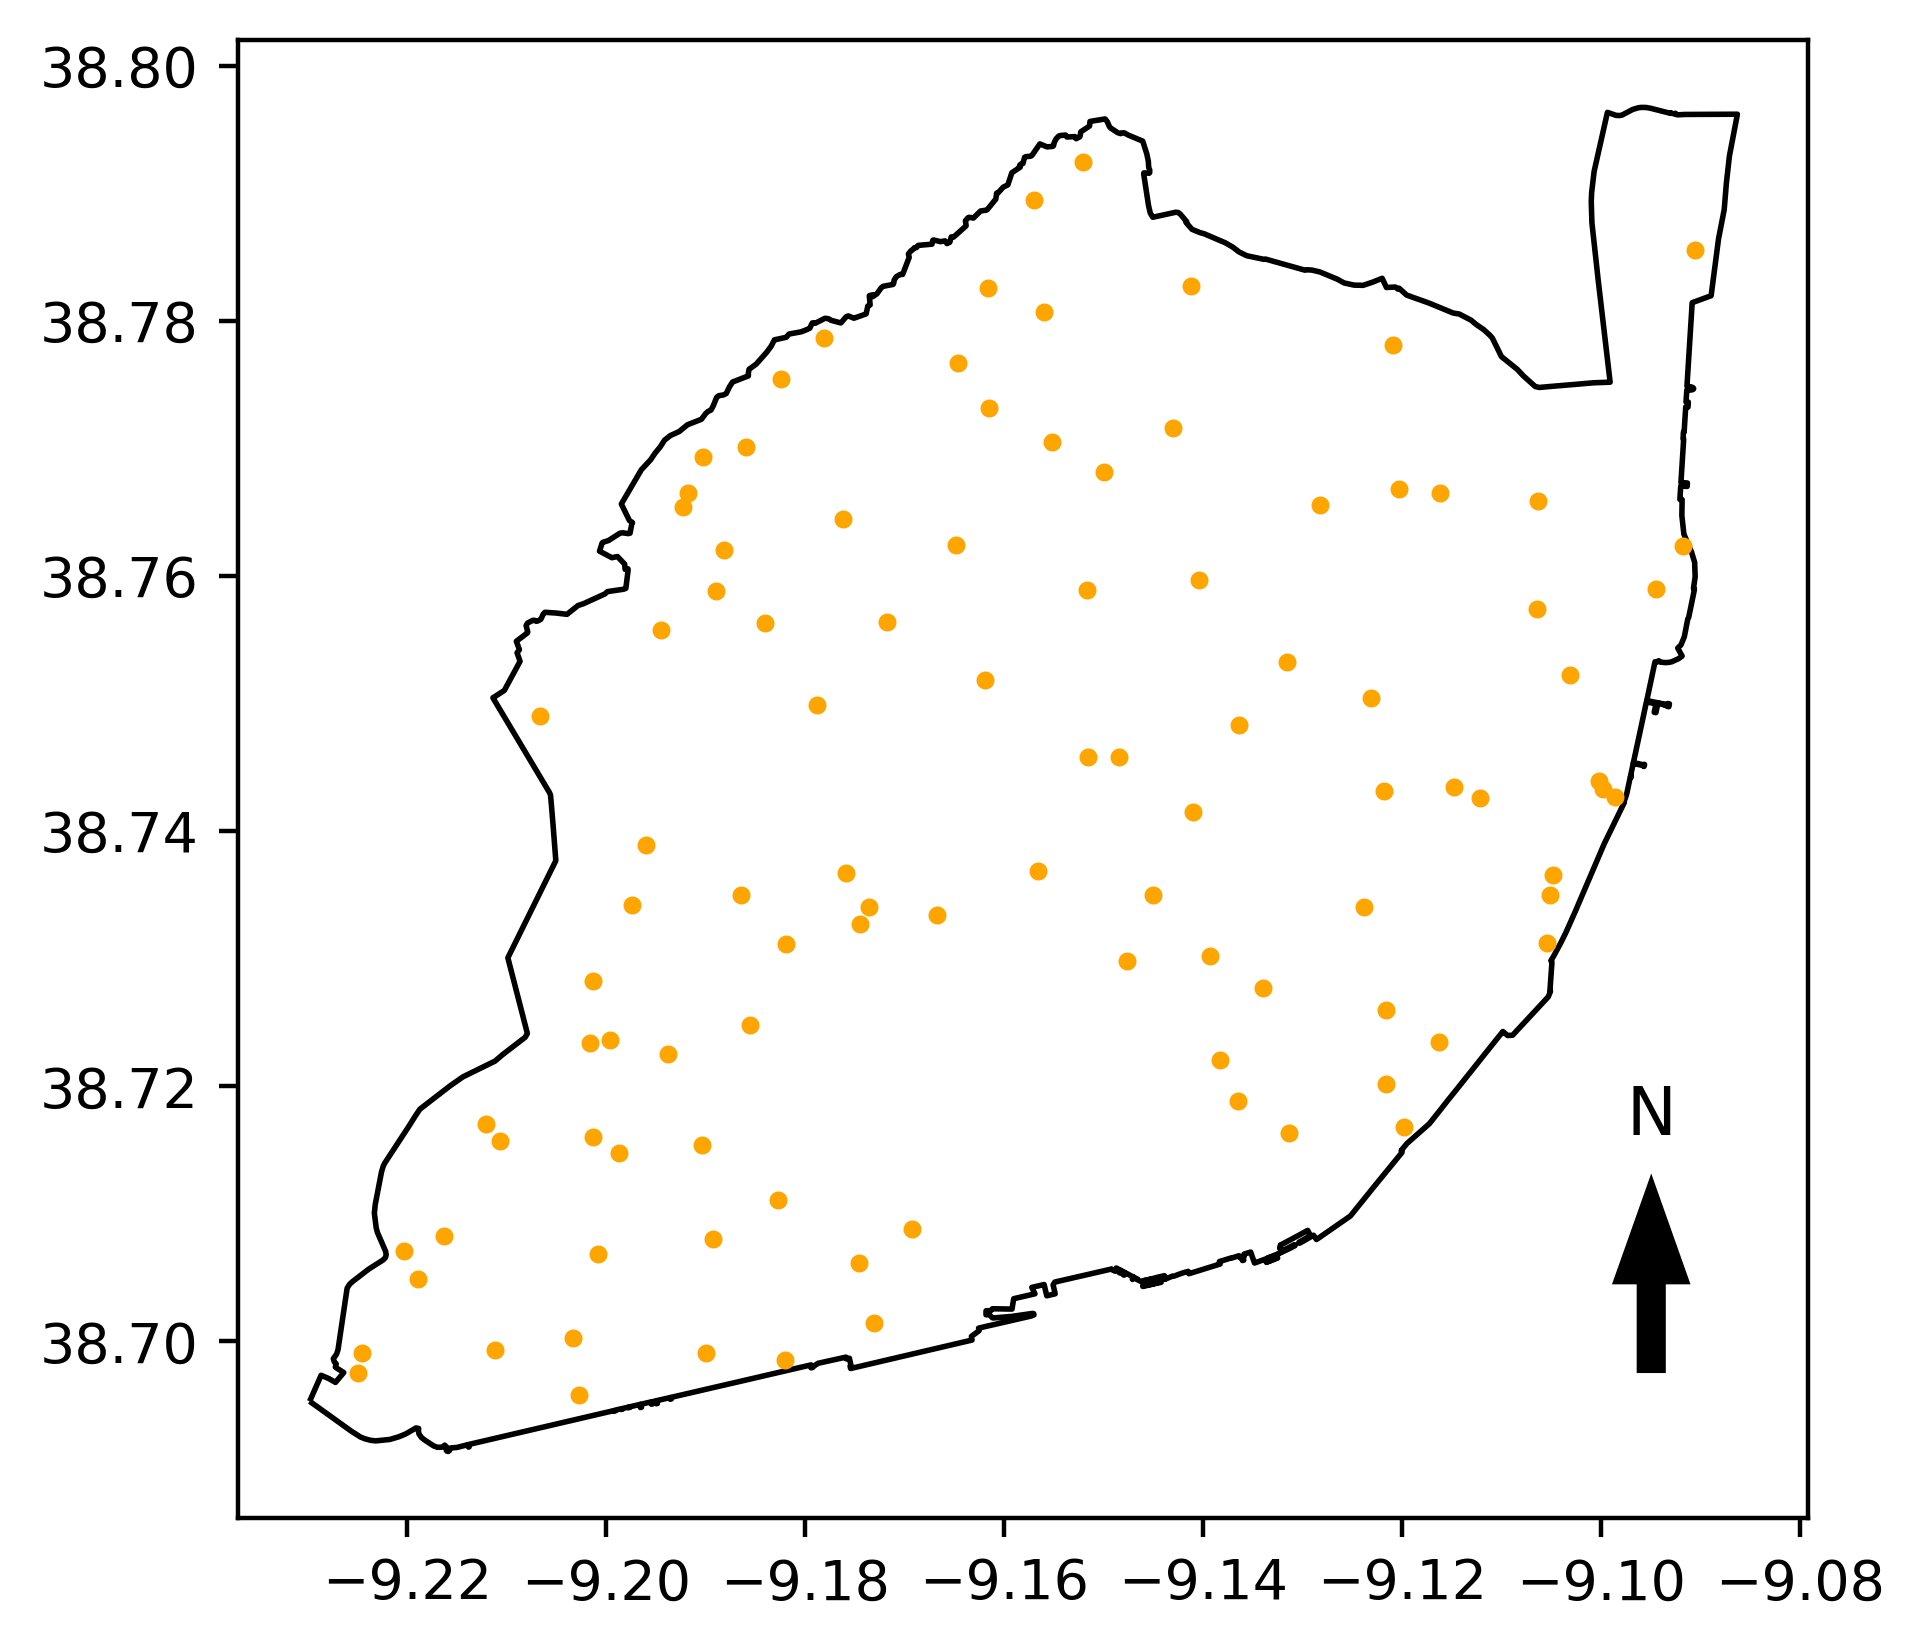

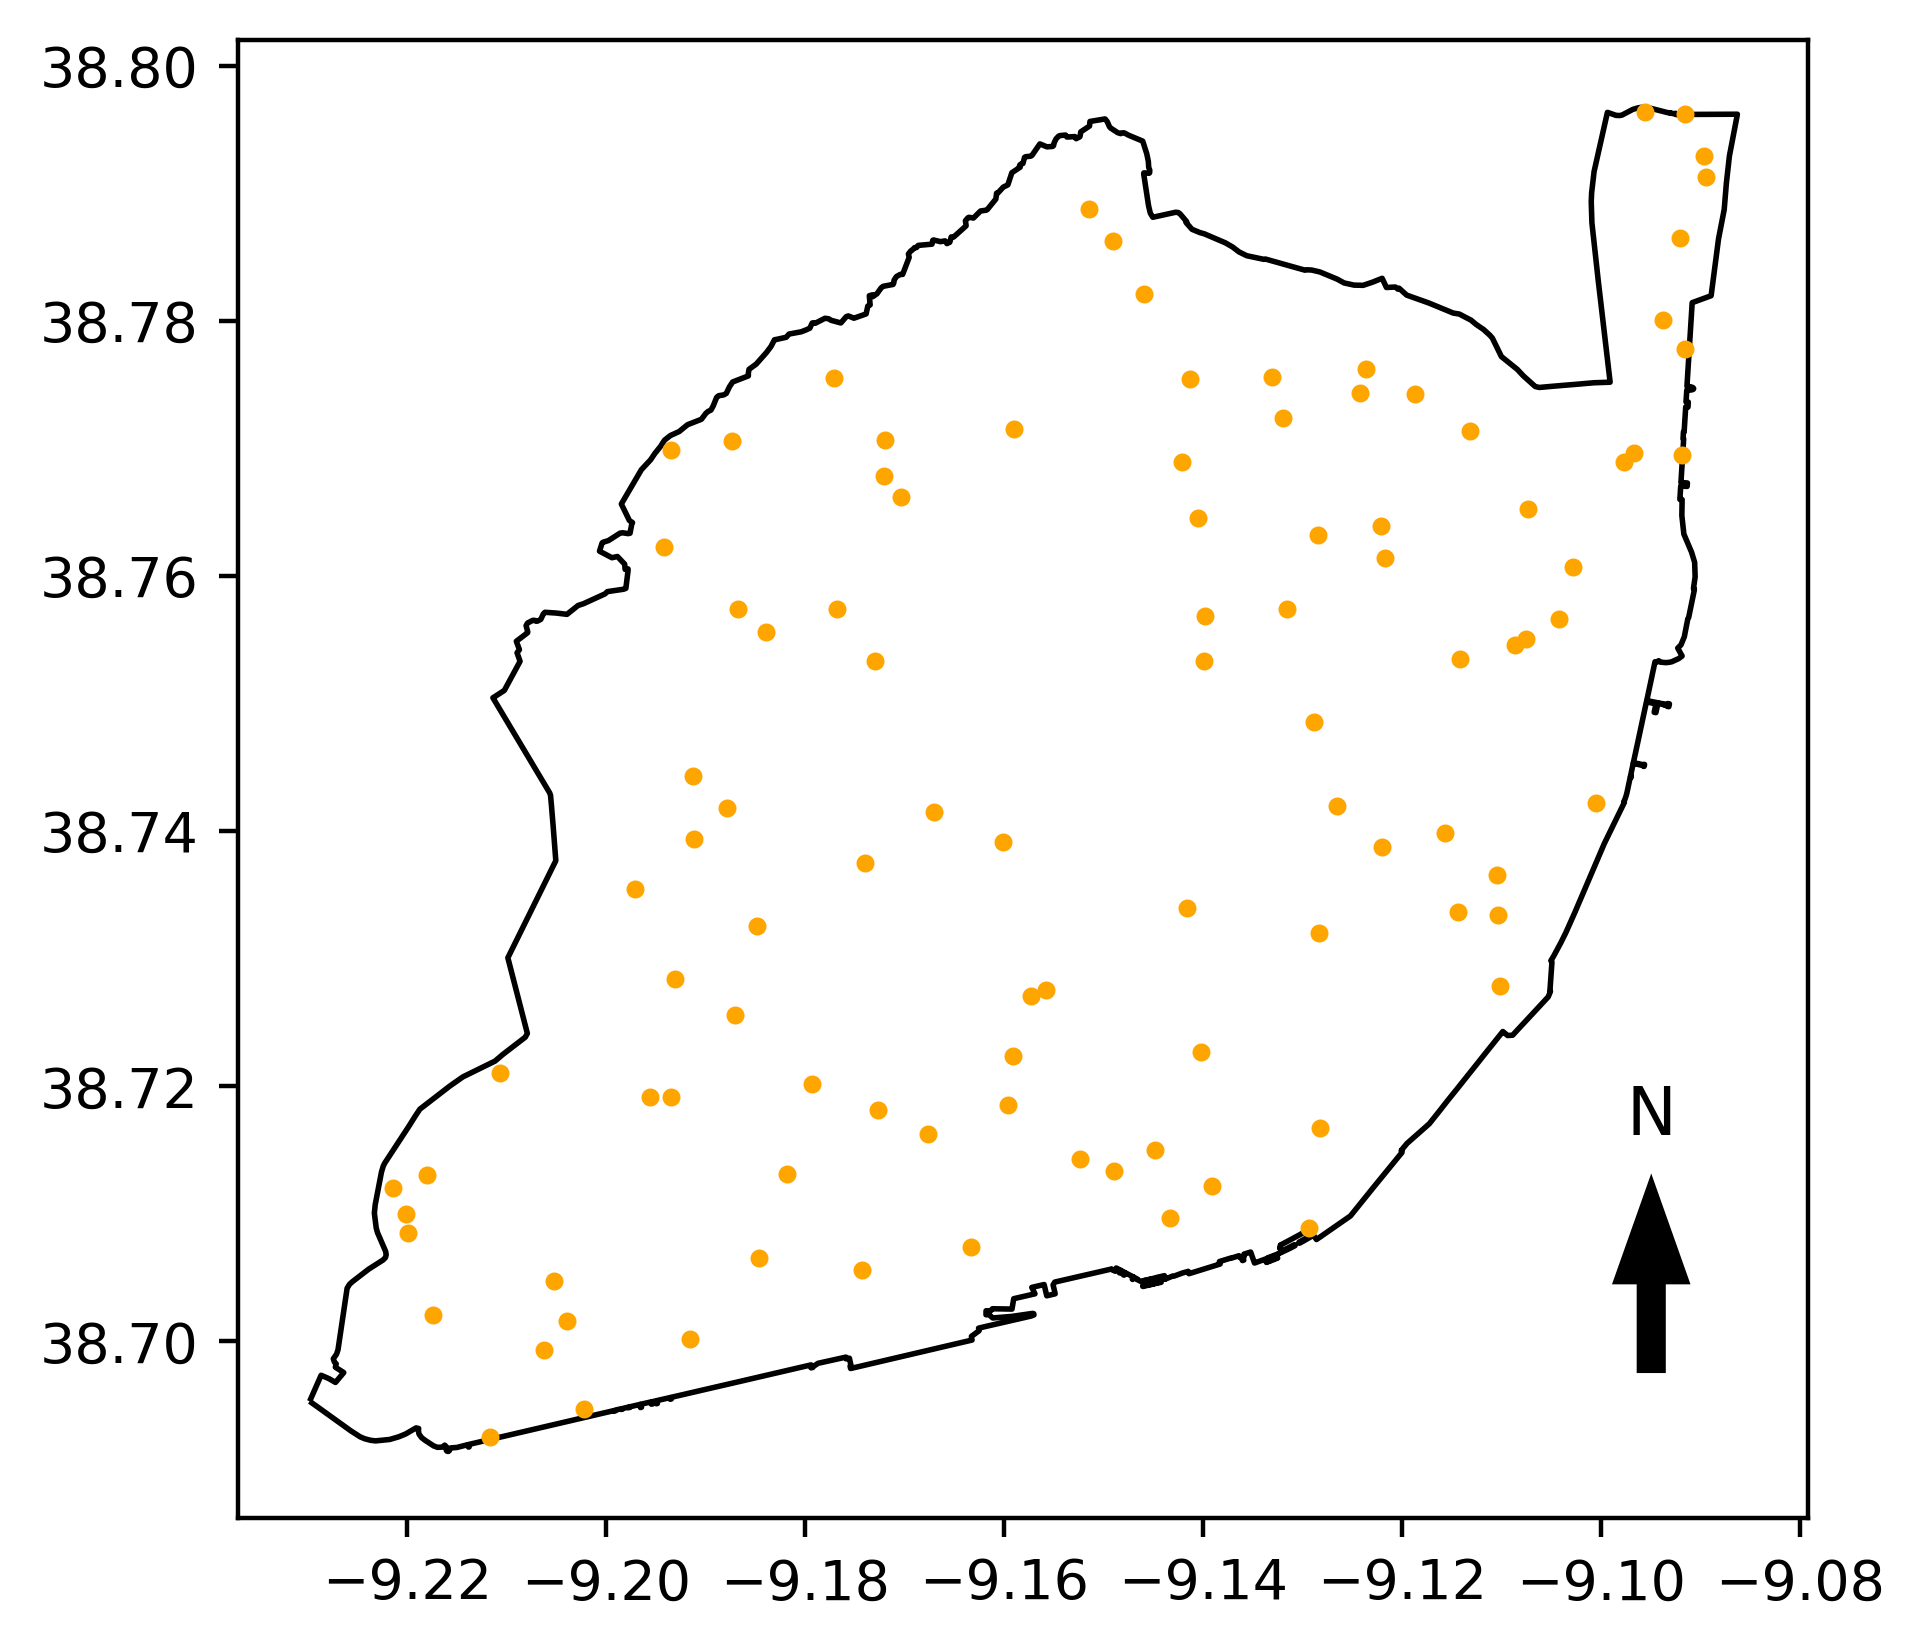

In [ ]:
import random


def plot_city_random_points(city_boundary, N_random_points):
    """Plot the city boundary and N random points within the boundary.

    Args:
        city_boundary (geopandas.GeoDataFrame): The boundary of the city.
        N_random_points (int): The number of random points to plot.

    Returns:
        matplotlib.figure.Figure: The plotted figure.
    """
    polygon = city_boundary.geometry[0]
    minx, miny, maxx, maxy = polygon.bounds
    points = []

    while len(points) < N_random_points:
        random_point = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(random_point):
            points.append(random_point)

    random_points_gdf = gpd.GeoDataFrame(geometry=points, crs="EPSG:4326")

    fig, ax = plt.subplots(dpi=400)
    city_boundary.plot(ax=ax, color='white', edgecolor='black')
    random_points_gdf.plot(ax=ax, color='orange', markersize=5)
    
    # Add a north
    ax.add_patch(FancyArrow(0.9, 0.1, 0.0, 0.06, width=0.015, transform=ax.transAxes, color='k'))
    ax.text(0.9, 0.25, 'N', transform=ax.transAxes, ha='center', va='bottom', fontsize=12)
    
    return fig


N_random_points = 100
plot_city_random_points(city_boundary, N_random_points)

# download image
# from google.colab import files
plot_city_random_points(city_boundary, N_random_points).savefig('lisbon_random_points.png',  bbox_inches="tight")
files.download('lisbon_random_points.png')